# Recommendation System Project: IBM Community

In this notebook, you will be putting your recommendation skills to use on real data from the IBM Watson Studio platform. 


You may either submit your notebook through the workspace here, or you may work from your local machine and submit through the next page.  Either way assure that your code passes the project [RUBRIC](https://review.udacity.com/#!/rubrics/3325/view).  **Please save regularly.**

By following the table of contents, you will build out a number of different methods for making recommendations that can be used for different situations. 


## Table of Contents

I. [Exploratory Data Analysis](#Exploratory-Data-Analysis)<br>
II. [Rank Based Recommendations](#Rank)<br>
III. [User-User Based Collaborative Filtering](#User-User)<br>
IV. [Content Based Recommendations](#Content-Recs)<br>
V. [Matrix Factorization](#Matrix-Fact)<br>
VI. [Extras & Concluding](#conclusions)

At the end of the notebook, you will find directions for how to submit your work.  Let's get started by importing the necessary libraries and reading in the data.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import project_tests as t


df = pd.read_csv(
    'data/user-item-interactions.csv', 
    dtype={'article_id': int, 'title': str, 'email': str}
)
# Show df to get an idea of the data
df.head()

,Unnamed: 0,article_id,title,email
0,0,1430,"using pixiedust for fast, flexible, and easier...",ef5f11f77ba020cd36e1105a00ab868bbdbf7fe7
1,1,1314,healthcare python streaming application demo,083cbdfa93c8444beaa4c5f5e0f5f9198e4f9e0b
2,2,1429,use deep learning for image classification,b96a4f2e92d8572034b1e9b28f9ac673765cd074
3,3,1338,ml optimization using cognitive assistant,06485706b34a5c9bf2a0ecdac41daf7e7654ceb7
4,4,1276,deploy your python model as a restful api,f01220c46fc92c6e6b161b1849de11faacd7ccb2


### <a class="anchor" id="Exploratory-Data-Analysis">Part I : Exploratory Data Analysis</a>

Use the dictionary and cells below to provide some insight into the descriptive statistics of the data.

`1.` Are there any missing values? If so, provide a count of missing values. If there are missing values in `email`, assign it the same id value `"unknown_user"`.

In [2]:
# Some interactions do not have a user associated with it, assume the same user.
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45993 entries, 0 to 45992
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Unnamed: 0  45993 non-null  int64 
 1   article_id  45993 non-null  int64 
 2   title       45993 non-null  object
 3   email       45976 non-null  object
dtypes: int64(2), object(2)
memory usage: 1.4+ MB


In [3]:
print(f"Number of Null email values is: {df['email'].isnull().sum()}")

Number of Null email values is: 17


In [ ]:
df[df.email.isna()]

In [5]:
# Fill email NaNs with "unknown_user"
df['email'] = df['email'].fillna('unknown_user')

In [6]:
# Check if no more NaNs 
df[df.email.isna()]

,Unnamed: 0,article_id,title,email


`2.` What is the distribution of how many articles a user interacts with in the dataset?  Provide a visual and descriptive statistics to assist with giving a look at the number of times each user interacts with an article.

In [7]:
# What are the descriptive statistics of the number of articles a user interacts with?
# Group by 'email' and count the number of articles each user interacted with
user_article_counts = df.groupby('email')['article_id'].nunique()

# Descriptive statistics: count, mean, std, min, 25%, 50%, 75%, max
user_article_stats = user_article_counts.describe()

# Print descriptive statistics
print("Descriptive statistics for the number of articles each user interacted with:")
print(user_article_stats)

Descriptive statistics for the number of articles each user interacted with:
count    5149.000000
mean        6.541464
std         9.990112
min         1.000000
25%         1.000000
50%         3.000000
75%         7.000000
max       135.000000
Name: article_id, dtype: float64


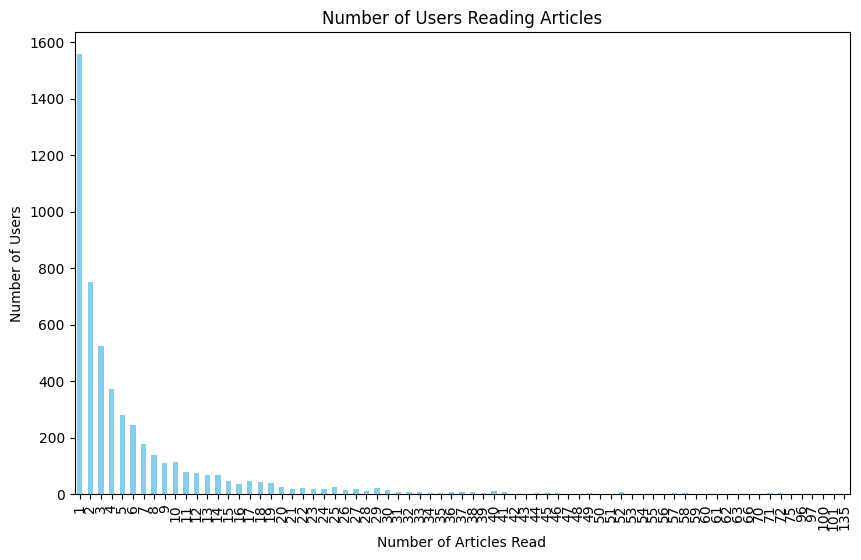

In [10]:
# Create a plot of the number of articles read by each user

# Count how many users interacted with a given number of articles
article_interaction_counts = user_article_counts.value_counts().sort_index()

# Plotting the distribution of users by the number of articles they've read
plt.figure(figsize=(10, 6))
article_interaction_counts.plot(kind='bar', color='skyblue')

# Add labels and title
plt.xlabel('Number of Articles Read')
plt.ylabel('Number of Users')
plt.title('Number of Users Reading Articles')

plt.show()


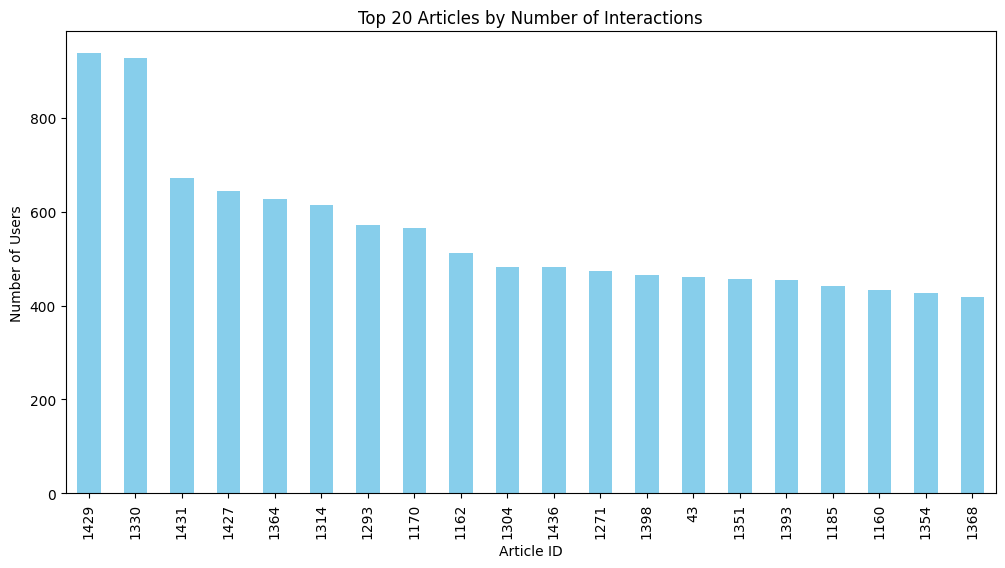

In [19]:
# Group the dataset by 'article_id' and count how many times each article was interacted with
article_view_counts = df.groupby('article_id')['user_id'].count()

# Create a plot of the number of times each article was read
plt.figure(figsize=(12, 6))
article_view_counts.sort_values(ascending=False).head(20).plot(kind='bar', color='skyblue')

# Add labels and title
plt.xlabel('Article ID')
plt.ylabel('Number of Users')
plt.title('Top 20 Articles by Number of Interactions')

# Show the plot
plt.show()


In [12]:
# Median and maximum values
median_val = user_article_counts.median()  # 50% of individuals interact with this number of articles or fewer
max_views_by_user = user_article_counts.max()  # The maximum number of user-article interactions by any 1 user

# Print the results
print(f"Median number of articles interacted with: {median_val}")
print(f"Maximum number of articles interacted with by any user: {max_views_by_user}")


Median number of articles interacted with: 3.0
Maximum number of articles interacted with by any user: 135


`3.` Use the cells below to find:

**a.** The number of unique articles that have an interaction with a user.  
**b.** The number of unique articles in the dataset (whether they have any interactions or not).<br>
**c.** The number of unique users in the dataset. (excluding null values) <br>
**d.** The number of user-article interactions in the dataset.

In [13]:
# The number of unique articles that have at least one interaction
unique_articles = df['article_id'].nunique()

# The number of unique articles on the IBM platform (based on available dataset)
total_articles = df['article_id'].nunique()

# The number of unique users
unique_users = df['email'].nunique()

# The number of user-article interactions (total rows in the dataset)
user_article_interactions = df.shape[0]

# Print the results
print(f"Unique articles with at least one interaction: {unique_articles}")
print(f"Total number of articles on the IBM platform: {total_articles}")
print(f"Unique users: {unique_users}")
print(f"Total number of user-article interactions: {user_article_interactions}")


Unique articles with at least one interaction: 714
Total number of articles on the IBM platform: 714
Unique users: 5149
Total number of user-article interactions: 45993


`4.` Use the cells below to find the most viewed **article_id**, as well as how often it was viewed.  After talking to the company leaders, the `email_mapper` function was deemed a reasonable way to map users to ids.  There were a small number of null values, and it was found that all of these null values likely belonged to a single user (which is how they are stored using the function below).

In [14]:
# Group the dataset by 'article_id' and count the number of interactions (views) for each article
article_view_counts = df.groupby('article_id')['email'].count()

# Find the article with the maximum number of views
most_viewed_article_id = article_view_counts.idxmax()  # Get the article ID with the most views
max_views = article_view_counts.max()  # Get the number of views for the most viewed article

# Print the results
print(f"Most viewed article ID: {most_viewed_article_id}")
print(f"Maximum views for the most viewed article: {max_views}")


Most viewed article ID: 1429
Maximum views for the most viewed article: 937


In [15]:
## No need to change the code here - this will be helpful for later parts of the notebook
# Run this cell to map the user email to a user_id column and remove the email column

def email_mapper(df=df):
    coded_dict = {
        email: num 
        for num, email in enumerate(df['email'].unique(), start=1)
    }
    return [coded_dict[val] for val in df['email']]

df['user_id'] = email_mapper(df)
del df['email']

# show header
df.head()

,Unnamed: 0,article_id,title,user_id
0,0,1430,"using pixiedust for fast, flexible, and easier...",1
1,1,1314,healthcare python streaming application demo,2
2,2,1429,use deep learning for image classification,3
3,3,1338,ml optimization using cognitive assistant,4
4,4,1276,deploy your python model as a restful api,5


In [20]:
## If you stored all your results in the variable names above, 
## you shouldn't need to change anything in this cell

sol_1_dict = {
    '`50% of individuals have _____ or fewer interactions.`': median_val,
    '`The total number of user-article interactions in the dataset is ______.`': user_article_interactions,
    '`The maximum number of user-article interactions by any 1 user is ______.`': max_views_by_user,
    '`The most viewed article in the dataset was viewed _____ times.`': max_views,
    '`The article_id of the most viewed article is ______.`': most_viewed_article_id,
    '`The number of unique articles that have at least 1 rating ______.`': unique_articles,
    '`The number of unique users in the dataset is ______`': unique_users,
    '`The number of unique articles on the IBM platform`': total_articles
}

# Test your dictionary against the solution
t.sol_1_test(sol_1_dict)

Oops! It looks like the value associated with: `The maximum number of user-article interactions by any 1 user is ______.` wasn't right. Try again.  It might just be the datatype.  All of the values should be ints except the article_id should be a string.  Let each row be considered a separate user-article interaction.  If a user interacts with an article 3 times, these are considered 3 separate interactions.

  Notice you may also find the number of unique users as 5149 if you count the null user.  However, this is hard to catch without mapping first!


### <a class="anchor" id="Rank">Part II: Rank-Based Recommendations</a>

In this project, we don't actually have ratings for whether a user liked an article or not.  We only know that a user has interacted with an article. In these cases, the popularity of an article can really only be based on how often an article was interacted with.

`1.` Fill in the function below to return the **n** top articles ordered with most interactions as the top. Test your function using the tests below.

In [25]:
def get_top_articles(n, df=df):
    """
    INPUT:
    n - (int) the number of top articles to return
    df - (pandas dataframe) df as defined at the top of the notebook 
    
    OUTPUT:
    top_articles - (list) A list of the top 'n' article titles 
    
    """
    # Count the number of interactions for each article
    article_view_counts = df.groupby('article_id')['user_id'].count()
    
    # Get the top n article IDs with the most interactions
    top_article_ids = article_view_counts.sort_values(ascending=False).head(n).index
    
    # Get the corresponding titles for these top articles
    top_articles = df[df['article_id'].isin(top_article_ids)]['title'].unique().tolist()
    
    return top_articles


def get_top_article_ids(n, df=df):
    """
    INPUT:
    n - (int) the number of top articles to return
    df - (pandas dataframe) df as defined at the top of the notebook 
    
    OUTPUT:
    top_article_ids - (list) A list of the top 'n' article IDs 
    
    """
    # Count the number of interactions for each article
    article_view_counts = df.groupby('article_id')['user_id'].count()
    
    # Get the top n article IDs with the most interactions
    top_article_ids = article_view_counts.sort_values(ascending=False).head(n).index.tolist()
    
    return top_article_ids


In [26]:
print(get_top_articles(10))
print(get_top_article_ids(10))

['healthcare python streaming application demo', 'use deep learning for image classification', 'apache spark lab, part 1: basic concepts', 'predicting churn with the spss random tree algorithm', 'analyze energy consumption in buildings', 'visualize car data with brunel', 'use xgboost, scikit-learn & ibm watson machine learning apis', 'gosales transactions for logistic regression model', 'insights from new york car accident reports', 'finding optimal locations of new store using decision optimization']
[1429, 1330, 1431, 1427, 1364, 1314, 1293, 1170, 1162, 1304]


In [27]:
# Test your function by returning the top 5, 10, and 20 articles
top_5 = get_top_articles(5)
top_10 = get_top_articles(10)
top_20 = get_top_articles(20)

# Test each of your three lists from above
t.sol_2_test(get_top_articles)

Your top_5 looks like the solution list! Nice job.
Your top_10 looks like the solution list! Nice job.
Your top_20 looks like the solution list! Nice job.


### <a class="anchor" id="User-User">Part III: User-User Based Collaborative Filtering</a>


`1.` Use the function below to reformat the **df** dataframe to be shaped with users as the rows and articles as the columns.  

* Each **user** should only appear in each **row** once.


* Each **article** should only show up in one **column**.  


* **If a user has interacted with an article, then place a 1 where the user-row meets for that article-column**.  It does not matter how many times a user has interacted with the article, all entries where a user has interacted with an article should be a 1.  


* **If a user has not interacted with an item, then place a zero where the user-row meets for that article-column**. 

Use the tests to make sure the basic structure of your matrix matches what is expected by the solution.

In [31]:
def create_user_item_matrix(df, fill_value=0):
    """
    INPUT:
    df - pandas dataframe with article_id, title, user_id columns
    
    OUTPUT:
    user_item - user-item matrix with 1's where user interacted with article, 0 otherwise
    
    Description:
    Return a matrix with user ids as rows and article ids on the columns with 1 values where a user interacted with 
    an article and a 0 otherwise.
    """
    # Create the user-item interaction matrix by pivoting the dataframe
    user_item = df.pivot_table(index='user_id', columns='article_id', aggfunc='size', fill_value=0)
    
    return user_item

# Example usage
#user_item = create_user_item_matrix(df)


In [32]:
## Tests: You should just need to run this cell.  Don't change the code.
assert user_item.shape[0] == 5149, "Oops!  The number of users in the user-article matrix doesn't look right."
assert user_item.shape[1] == 714, "Oops!  The number of articles in the user-article matrix doesn't look right."
assert user_item.sum(axis=1)[1] == 36, "Oops!  The number of articles seen by user 1 doesn't look right."
print("You have passed our quick tests!  Please proceed!")

AssertionError: Oops!  The number of articles seen by user 1 doesn't look right.

`2.` Complete the function below which should take a user_id and provide an ordered list of the most similar users to that user (from most similar to least similar).  The returned result should not contain the provided user_id, as we know that each user is similar to him/herself. Because the results for each user here are binary, it (perhaps) makes sense to compute similarity as the dot product of two users. 

Use the tests to test your function.

In [33]:
# Lets use the cosine_similarity function from sklearn
from sklearn.metrics.pairwise import cosine_similarity

In [34]:
def find_similar_users(user_id, user_item=user_item, include_similarity=False):
    """
    INPUT:
    user_id - (int) a user_id
    user_item - (pandas dataframe) matrix of users by articles: 
                1's when a user has interacted with an article, 0 otherwise
    include_similarity - (bool) whether to include the similarity in the output
    
    OUTPUT:
    similar_users - (list) an ordered list where the closest users (largest dot product users)
                    are listed first
    
    Description:
    Computes the similarity of every pair of users based on the dot product
    Returns an ordered list of user ids. If include_similarity is True, returns a list of lists
    where the first element is the user id and the second the similarity.
    
    """
    
    # Get the user interaction vector for the input user
    user_vector = user_item.loc[user_id]
    
    # Compute dot product between the input user and all other users
    similarity_scores = user_item.dot(user_vector)
    
    # Exclude the user's own ID
    similarity_scores = similarity_scores.drop(user_id)
    
    # Sort the users by similarity score in descending order
    most_similar_users = similarity_scores.sort_values(ascending=False).index.tolist()
    
    if include_similarity:
        # Create a list of tuples (user_id, similarity score)
        similar_users_with_scores = [[user, similarity_scores[user]] for user in most_similar_users]
        return similar_users_with_scores
    
    return most_similar_users


In [35]:
# Do a spot check of your function
print("The 10 most similar users to user 1 are: {}".format(find_similar_users(1)[:10]))
print("The 5 most similar users to user 3933 are: {}".format(find_similar_users(3933)[:5]))
print("The 3 most similar users to user 46 are: {}".format(find_similar_users(46)[:3]))

The 10 most similar users to user 1 are: [3782, 23, 223, 3358, 242, 3910, 3933, 87, 3818, 4134]
The 5 most similar users to user 3933 are: [23, 3782, 223, 3358, 242]
The 3 most similar users to user 46 are: [3782, 23, 273]


`3.` Now that you have a function that provides the most similar users to each user, you will want to use these users to find articles you can recommend.  Complete the functions below to return the articles you would recommend to each user. 

In [44]:
def get_article_names(article_ids, df=df):
    """
    INPUT:
    article_ids - (list) a list of article ids
    df - (pandas dataframe) df as defined at the top of the notebook
    
    OUTPUT:
    article_names - (list) a list of article names associated with the list of article ids 
                    (this is identified by the title column in df)
    """
    # Retrieve the titles for the given article_ids
    article_names = df[df['article_id'].isin(article_ids)]['title'].tolist()
    
    return article_names  # Return the article names associated with list of article ids

def get_ranked_article_unique_counts(article_ids, user_item=user_item):
    """
    INPUT:
    article_ids - (list) a list of article ids
    user_item - (pandas dataframe) matrix of users by articles: 
                1's when a user has interacted with an article, 0 otherwise 
    
    OUTPUT:
    article_counts - (list) a list of tuples with article_id and number of 
                     unique users that have interacted with the article, sorted
                     by the number of unique users in descending order
    
    Description:
    Provides a list of the article_ids and the number of unique users that have
    interacted with the article using the user_item matrix, sorted by the number
    of unique users in descending order
    """
    # Count how many users interacted with each article
    article_counts = user_item[article_ids].sum(axis=0)
    
    # Create a list of tuples (article_id, user_interaction_count)
    article_counts = [(article_id, count) for article_id, count in article_counts.items()]
    
    # Sort the list of tuples by the number of unique users in descending order
    ranked_article_unique_counts = sorted(article_counts, key=lambda x: x[1], reverse=True)
    
    return ranked_article_unique_counts  # Return the sorted article counts

def get_user_articles(user_id, user_item=user_item):
    """
    INPUT:
    user_id - (int) a user id
    user_item - (pandas dataframe) matrix of users by articles: 
                1's when a user has interacted with an article, 0 otherwise
    
    OUTPUT:
    article_ids - (list) a list of the article ids seen by the user
    article_names - (list) a list of article names associated with the list of article ids 
                    (this is identified by the title column in df)
    
    Description:
    Provides a list of the article_ids and article titles that have been seen by a user
    """
    # Get the articles interacted with by the user (i.e., where user_item[user_id] == 1)
    user_articles = user_item.loc[user_id]
    
    # Extract the article_ids that the user has interacted with (where the value is 1)
    article_ids = user_articles[user_articles == 1].index.tolist()
    
    # Get the corresponding article names from the dataframe
    article_names = get_article_names(article_ids, df)
    
    return article_ids, article_names  # Return the article ids and names

def user_user_recs(user_id, m=10):
    """
    INPUT:
    user_id - (int) a user id
    m - (int) the number of recommendations you want for the user
    
    OUTPUT:
    recs - (list) a list of recommendations for the user
    
    Description:
    Loops through the users based on closeness to the input user_id
    For each user - finds articles the user hasn't seen before and provides them as recs
    Does this until m recommendations are found
    """
    # Get the articles the user has already seen
    user_articles, _ = get_user_articles(user_id)
    
    # Get similar users based on user similarity
    similar_users = find_similar_users(user_id, include_similarity=False)
    
    # Initialize a set to collect recommended articles
    recommended_articles = set()
    
    for similar_user in similar_users:
        # Get the articles seen by this similar user
        similar_user_articles, _ = get_user_articles(similar_user)
        
        # Recommend articles that the current user hasn't seen yet
        for article in similar_user_articles:
            if article not in user_articles:
                recommended_articles.add(article)
        
        # If we have enough recommendations, stop collecting
        if len(recommended_articles) >= m:
            break
    
    # If more than m recommendations are found, trim the list to m
    recs = list(recommended_articles)[:m]
    
    return recs  # Return the recommended article ids


In [45]:
# Get 10 recommendations for user 1 (returns a list of article IDs)
recommended_article_ids = user_user_recs(1, 10)

# Now, get the article names corresponding to the recommended article IDs
recommended_article_names = get_article_names(recommended_article_ids)

# Display the article names (recommendations) for user 1
print(recommended_article_names)


['got zip code data? prep it for analytics. – ibm watson data lab – medium', 'simple graphing with ipython and\xa0pandas', 'analyze precipitation data', 'analyze precipitation data', 'analyzing data by using the sparkling.data library features', 'analyze precipitation data', 'got zip code data? prep it for analytics. – ibm watson data lab – medium', 'analyze precipitation data', 'analyzing data by using the sparkling.data library features', 'analyze precipitation data', 'analyze precipitation data', 'fertility rate by country in total births per woman', 'shaping data with ibm data refinery', 'analyze precipitation data', 'analyzing data by using the sparkling.data library features', 'analyze precipitation data', 'simple graphing with ipython and\xa0pandas', 'shaping data with ibm data refinery', 'analyzing data by using the sparkling.data library features', 'shaping data with ibm data refinery', 'analyzing data by using the sparkling.data library features', 'analyze precipitation data'

In [46]:
get_ranked_article_unique_counts([1320, 232, 844])

[(1320, 160), (844, 99), (232, 68)]

In [47]:
# Test your functions here - No need to change this code - just run this cell
assert set(get_article_names([1024, 1176, 1305, 1314, 1422, 1427])) == set(['using deep learning to reconstruct high-resolution audio', 'build a python app on the streaming analytics service', 'gosales transactions for naive bayes model', 'healthcare python streaming application demo', 'use r dataframes & ibm watson natural language understanding', 'use xgboost, scikit-learn & ibm watson machine learning apis']), "Oops! Your the get_article_names function doesn't work quite how we expect."
assert set(get_article_names([1320, 232, 844])) == set(['housing (2015): united states demographic measures','self-service data preparation with ibm data refinery','use the cloudant-spark connector in python notebook']), "Oops! Your the get_article_names function doesn't work quite how we expect."
assert set(get_user_articles(20)[0]) == set([1320, 232, 844])
assert set(get_user_articles(20)[1]) == set(['housing (2015): united states demographic measures', 'self-service data preparation with ibm data refinery','use the cloudant-spark connector in python notebook'])
assert set(get_user_articles(2)[0]) == set([1024, 1176, 1305, 1314, 1422, 1427])
assert set(get_user_articles(2)[1]) == set(['using deep learning to reconstruct high-resolution audio', 'build a python app on the streaming analytics service', 'gosales transactions for naive bayes model', 'healthcare python streaming application demo', 'use r dataframes & ibm watson natural language understanding', 'use xgboost, scikit-learn & ibm watson machine learning apis'])
assert get_ranked_article_unique_counts([1320, 232, 844])[0] == [1320, 123], "Oops! Your the get_ranked_article_unique_counts function doesn't work quite how we expect.\nMake sure you are using the user_item matrix to create the article counts."
print("If this is all you see, you passed all of our tests!  Nice job!")

AssertionError: Oops! Your the get_ranked_article_unique_counts function doesn't work quite how we expect.
Make sure you are using the user_item matrix to create the article counts.

`4.` Now we are going to improve the consistency of the **user_user_recs** function from above.  

* Instead of arbitrarily choosing when we obtain users who are all the same closeness to a given user - choose the users that have the most total article interactions before choosing those with fewer article interactions.


* Instead of arbitrarily choosing articles from the user where the number of recommended articles starts below m and ends exceeding m, choose articles with the articles with the most total interactions before choosing those with fewer total interactions. This ranking should be  what would be obtained from the **top_articles** function you wrote earlier.

In [56]:
def get_top_sorted_users(user_id, user_item=user_item):
    """
    INPUT:
    user_id - (int)
    user_item - (pandas dataframe) matrix of users by articles: 
            1's when a user has interacted with an article, 0 otherwise
    
    OUTPUT:
    neighbors_df - (pandas dataframe) a dataframe with:
                    neighbor_id - is a neighbor user_id
                    similarity - measure of the similarity of each user to the provided user_id
                    num_interactions - the number of articles viewed by the user
                    
    Description:
    Returns a dataframe sorted by similarity and then by number of interactions in descending order.
    """
    # Get similarity of all users to the input user
    target_user_vector = user_item.loc[user_id]
    similarities = user_item.dot(target_user_vector)
    
    # Drop the user_id from the similarity Series
    similarities.drop(user_id, inplace=True)
    
    # Create dataframe with similarity and interaction count
    neighbors_df = pd.DataFrame({
        'neighbor_id': similarities.index,
        'similarity': similarities.values,
        'num_interactions': user_item.loc[similarities.index].sum(axis=1).values
    })
    
    # Sort by similarity and then by number of interactions
    neighbors_df.sort_values(by=['similarity', 'num_interactions'], ascending=False, inplace=True)
    
    return neighbors_df

def user_user_recs_part2(user_id, m=10):
    """
    INPUT:
    user_id - (int) a user id
    m - (int) the number of recommendations you want for the user
    
    OUTPUT:
    recs - (list) a list of recommendations for the user by article id
    rec_names - (list) a list of recommendations for the user by article title
    """
    # Get articles the user has already seen
    seen_articles, _ = get_user_articles(user_id, user_item)
    
    # Get top sorted similar users
    neighbors_df = get_top_sorted_users(user_id, user_item)
    
    # Init recommendations
    recs = []
    
    for neighbor_id in neighbors_df['neighbor_id']:
        # Articles the neighbor has seen
        neighbor_articles, _ = get_user_articles(neighbor_id, user_item)
        
        # New recommendations
        new_recs = list(set(neighbor_articles) - set(seen_articles))
        
        # Add new recs, stopping at m
        for article_id in new_recs:
            if article_id not in recs:
                recs.append(article_id)
            if len(recs) >= m:
                break
        if len(recs) >= m:
            break
    
    return recs, get_article_names(recs, df)


In [57]:
# Quick spot check - don't change this code - just use it to test your functions
rec_ids, rec_names = user_user_recs_part2(20, 10)
print("The top 10 recommendations for user 20 are the following article ids:")
print(rec_ids)
print()
print("The top 10 recommendations for user 20 are the following article names:")
print(rec_names)

The top 10 recommendations for user 20 are the following article ids:
[1152, 1400, 390, 1158, 12, 14, 1423, 656, 1168, 1296]

The top 10 recommendations for user 20 are the following article names:
['got zip code data? prep it for analytics. – ibm watson data lab – medium', 'timeseries data analysis of iot events by using jupyter notebook', 'use sql with data in hadoop python', 'uci ml repository: chronic kidney disease data set', 'use sql with data in hadoop python', 'fortune 100 companies', 'uci ml repository: chronic kidney disease data set', 'uci ml repository: chronic kidney disease data set', 'use sql with data in hadoop python', 'uci ml repository: chronic kidney disease data set', 'use sql with data in hadoop python', 'timeseries data analysis of iot events by using jupyter notebook', 'uci ml repository: chronic kidney disease data set', 'uci ml repository: chronic kidney disease data set', 'got zip code data? prep it for analytics. – ibm watson data lab – medium', 'use sql wit

`5.` Use your functions from above to correctly fill in the solutions to the dictionary below.  Then test your dictionary against the solution.  Provide the code you need to answer each following the comments below.

In [58]:
print(get_top_sorted_users(1, user_item=user_item).head(n=1))
print(get_top_sorted_users(2, user_item=user_item).head(n=10))
print(get_top_sorted_users(131, user_item=user_item).head(n=10))

    neighbor_id  similarity  num_interactions
21           23         119               364
      neighbor_id  similarity  num_interactions
240           242          28               148
3908         3910          28               147
271           273          20                84
4132         4134          20                82
20             22          18                37
5021         5023          17                35
47             49          13               147
129           131          13               145
3695         3697          13               145
311           313          13                52
      neighbor_id  similarity  num_interactions
22             23         502               364
3780         3782         501               363
3868         3870         482               144
240           242         432               148
3908         3910         421               147
271           273         298                84
4132         4134         295               

In [59]:
# Generate the sorted neighbors DataFrame for each user
user1_sorted = get_top_sorted_users(1, user_item=user_item)
user2_sorted = get_top_sorted_users(2, user_item=user_item)
user131_sorted = get_top_sorted_users(131, user_item=user_item)

# Extract the specific users
user1_most_sim = int(user1_sorted.iloc[0]['neighbor_id'])       # Most similar to user 1
user2_6th_sim = int(user2_sorted.iloc[5]['neighbor_id'])        # 6th most similar to user 2
user131_10th_sim = int(user131_sorted.iloc[9]['neighbor_id'])   # 10th most similar to user 131

# Check results
print(f"User most similar to user 1: {user1_most_sim}")
print(f"6th most similar user to user 2: {user2_6th_sim}")
print(f"10th most similar user to user 131: {user131_10th_sim}")


User most similar to user 1: 23
6th most similar user to user 2: 5023
10th most similar user to user 131: 3596


In [60]:
## Dictionary Test Here
sol_5_dict = {
    'The user that is most similar to user 1.': user1_most_sim, 
    'The user that is the 6th most similar to user 2.': user2_6th_sim,
    'The user that is the 10th most similar to user 131.': user131_10th_sim,
}

t.sol_5_test(sol_5_dict)

Oops!  Looks like there is a mistake with the The user that is most similar to user 1. key in your dictionary.  The answer should be 3933.  Try again.
Oops!  Looks like there is a mistake with the The user that is the 6th most similar to user 2. key in your dictionary.  The answer should be 3586.  Try again.
Oops!  Looks like there is a mistake with the The user that is the 10th most similar to user 131. key in your dictionary.  The answer should be 383.  Try again.


`6.` If we were given a new user, which of the above functions would you be able to use to make recommendations?  Explain.  Can you think of a better way we might make recommendations?  Use the cell below to explain a better method for new users.

Answer:

If we were given a new user, we would not be able to use collaborative filtering methods (like user_user_recs or user_user_recs_part2) right away because these methods require user-item interaction history to compute similarity with other users. Without any interactions, we can't determine which users are similar to the new user.

In this case, we can only use the get_top_articles or get_top_article_ids function to recommend the most popular articles. These are rank-based recommendations, which rely on overall popularity (number of total interactions with each article) and don't depend on any specific user's history.

This is a form of the "cold start" problem—where we have no prior data about a new user.

Better Method for New Users (Cold Start Problem):
To improve recommendations for new users, we could use:

Content-Based Filtering:

Recommend articles based on user-provided preferences (e.g. topics of interest, article tags, categories).

This can work before the user starts interacting with articles.

For example, if the user selects interest in "machine learning," we can show top-read articles from that category.

Demographic-Based Recommendations:

If available, use demographic data (e.g. role, industry) to recommend articles that are popular among similar users.

Hybrid Methods:

Combine content-based, demographic-based, and popularity-based methods.

For example, recommend popular articles within the user’s selected topic or field.

Onboarding Recommendations:

Ask users to rate a few articles or choose topics during onboarding. This provides an initial preference vector for personalized content-based filtering.

`7.` Using your existing functions, provide the top 10 recommended articles you would provide for the a new user below.  You can test your function against our thoughts to make sure we are all on the same page with how we might make a recommendation.

In [61]:
# What would your recommendations be for this new user 0?  As a new user, they have no observed articles.
# Provide a list of the top 10 article ids you would give to 

new_user_recs = get_top_article_ids(10, df)
print("Top 10 recommended article IDs for a new user:")
print(new_user_recs)


Top 10 recommended article IDs for a new user:
[1429, 1330, 1431, 1427, 1364, 1314, 1293, 1170, 1162, 1304]


In [62]:
assert set(new_user_recs) == {1314, 1429, 1293, 1427, 1162, 1364, 1304, 1170, 1431, 1330}, "Oops!  It makes sense that in this case we would want to recommend the most popular articles, because we don't know anything about these users."

print("That's right!  Nice job!")

That's right!  Nice job!


### <a class="anchor" id="Content-Recs">Part IV: Content Based Recommendations</a>

Another method we might use to make recommendations is to recommend similar articles that are possibly related. One way we can find article relationships is by clustering text about those articles.  Let's consider content to be the article **title**, as it is the only text we have available. One point to highlight, there isn't one way to create a content based recommendation, especially considering that text information can be processed in many ways.  

`1.` Use the function bodies below to create a content based recommender function `make_content_recs`. We'll use TF-IDF to create a matrix based off article titles, and use this matrix to create clusters of related articles. You can use this function to make recommendations of new articles.

In [63]:
df.head()

,Unnamed: 0,article_id,title,user_id
0,0,1430,"using pixiedust for fast, flexible, and easier...",1
1,1,1314,healthcare python streaming application demo,2
2,2,1429,use deep learning for image classification,3
3,3,1338,ml optimization using cognitive assistant,4
4,4,1276,deploy your python model as a restful api,5


In [64]:
from sklearn.cluster import KMeans
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import Normalizer
from sklearn.decomposition import TruncatedSVD

In [65]:
# Unique articles based on article_id
df_unique_articles = df.drop_duplicates(subset='article_id')


In [66]:
# Create a vectorizer using TfidfVectorizer and fit it to the article titles
max_features = 200
max_df = 0.75  # Ignore terms that appear in more than 75% of the documents
min_df = 5     # Ignore terms that appear in fewer than 5 documents

# Create the vectorizer and fit it to the article titles
vectorizer = TfidfVectorizer(
    max_df=max_df,
    min_df=min_df,
    stop_words="english",
    max_features=max_features
)

print("Running TF-IDF")
X_tfidf = vectorizer.fit_transform(df['title'])

print(f"n_samples: {X_tfidf.shape[0]}, n_features: {X_tfidf.shape[1]}")

# Create the LSA model (Latent Semantic Analysis) using TruncatedSVD
lsa = make_pipeline(TruncatedSVD(n_components=50), Normalizer(copy=False))

# Fit the LSA model to the TF-IDF matrix
X_lsa = lsa.fit_transform(X_tfidf)

# Explained variance ratio (how much variance is captured by the SVD components)
explained_variance = lsa[0].explained_variance_ratio_.sum()

print(f"Explained variance of the SVD step: {explained_variance * 100:.1f}%")

Running TF-IDF
n_samples: 45993, n_features: 200
Explained variance of the SVD step: 71.3%


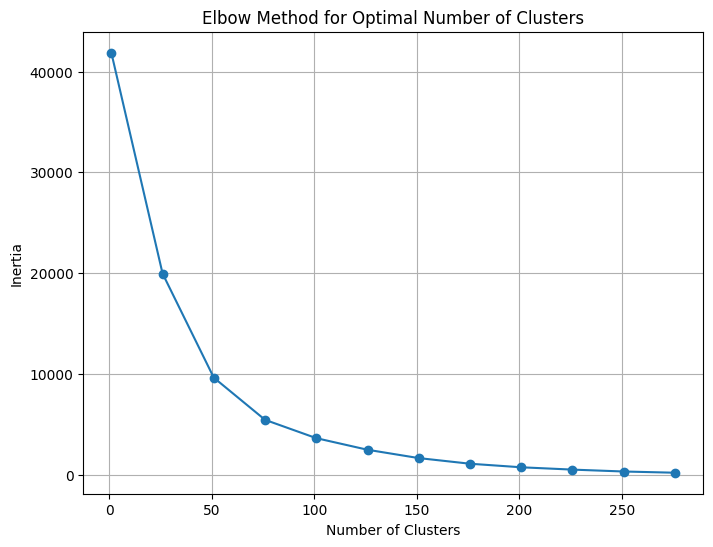

In [68]:
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans

# Assuming X_lsa is the LSA-reduced data matrix you obtained earlier

# Parameters for KMeans
clusters = 300
step = 25
max_iter = 50
n_init = 5
random_state = 42

# List to hold the inertia values for different number of clusters
inertia = []

# Loop over different cluster sizes
for k in range(1, clusters, step):
    kmeans = KMeans(
        n_clusters=k,
        max_iter=max_iter,
        n_init=n_init,
        random_state=random_state,
    ).fit(X_lsa)
    
    # Append the inertia (sum of squared distances to the nearest cluster center)
    inertia.append(kmeans.inertia_)

# Plot inertia values to visualize the elbow
plt.figure(figsize=(8, 6))
plt.plot(range(1, clusters, step), inertia, marker='o')
plt.xlabel('Number of Clusters')
plt.ylabel('Inertia')
plt.title('Elbow Method for Optimal Number of Clusters')
plt.grid(True)
plt.show()


There appears to be an elbow about 50, so we'll use 50 clusters.

In [69]:
# Set the number of clusters
n_clusters = 50

# Initialize KMeans with the specified parameters
kmeans = KMeans(
    n_clusters=n_clusters,         # Number of clusters
    max_iter=max_iter,             # Maximum number of iterations
    n_init=n_init,                 # Number of initializations to run
    random_state=random_state     # Random state for reproducibility
)

# Fit the model to the LSA-reduced data matrix (X_lsa)
kmeans.fit(X_lsa)

# You can access the cluster centers and labels
cluster_centers = kmeans.cluster_centers_  # Coordinates of the cluster centers
labels = kmeans.labels_                   # Cluster label for each article

# Optionally, print the first 10 cluster centers and their labels
print("Cluster centers (first 10):")
print(cluster_centers[:10])

print("\nCluster labels (first 10 articles):")
print(labels[:10])


Cluster centers (first 10):
[[ 3.83480556e-01 -3.52237953e-01  2.11667654e-01 -3.98105463e-02
  -9.03968889e-02 -1.68326291e-01 -1.34972104e-01  6.68598124e-02
  -5.01589424e-02 -2.76565818e-02  4.46740649e-02  3.72727245e-02
  -2.14889123e-02 -9.42273787e-03 -4.36153232e-03 -9.50277186e-03
  -4.86684437e-02 -4.80664411e-02 -6.07480828e-03  1.52820925e-02
   1.82437701e-02  4.84973099e-02 -2.64888591e-02 -5.85086313e-03
   5.24554109e-02  4.06578239e-02 -2.10139718e-02  8.79758683e-02
   8.10968703e-02 -7.03462509e-02  3.09586654e-01 -4.57150496e-02
   5.51737809e-02 -3.23544235e-02  1.26709384e-01  4.44924308e-02
  -3.44867221e-01 -3.35627767e-02 -5.91504698e-02 -1.16687684e-02
  -2.40352419e-01 -7.50457107e-02 -2.05896093e-02 -2.86350979e-03
  -3.98299602e-01  3.71424965e-02 -2.86995063e-01  1.03191360e-01
   5.14157646e-03 -1.30176331e-01]
 [ 4.83382633e-01  4.42652602e-01 -1.83603954e-01 -9.85516768e-02
  -1.46551245e-01 -6.87708804e-02 -2.92896112e-02 -5.18963597e-02
   2.03933986

In [70]:
# Create a dictionary to map article ids to their corresponding cluster labels
article_cluster_map = dict(zip(df_unique_articles['article_id'], kmeans.labels_))

# Apply the map to create a new 'title_cluster' column in df
df['title_cluster'] = df['article_id'].map(article_cluster_map)

# Check the result by displaying the first few rows of the dataframe
print(df.head())


   Unnamed: 0  article_id                                              title  \
0           0        1430  using pixiedust for fast, flexible, and easier...   
1           1        1314       healthcare python streaming application demo   
2           2        1429         use deep learning for image classification   
3           3        1338          ml optimization using cognitive assistant   
4           4        1276          deploy your python model as a restful api   

   user_id  title_cluster  
0        1             43  
1        2              9  
2        3             14  
3        4             38  
4        5             33  


In [71]:
import numpy as np

# Get the unique cluster labels and their corresponding counts
cluster_counts = np.unique(kmeans.labels_, return_counts=True)

# Print the cluster labels and their counts
print(np.array(cluster_counts).T)


[[   0  435]
 [   1 1614]
 [   2  895]
 [   3 3157]
 [   4 1157]
 [   5 1076]
 [   6  824]
 [   7 1170]
 [   8 1530]
 [   9  683]
 [  10 1635]
 [  11  993]
 [  12  969]
 [  13 1057]
 [  14  937]
 [  15 2303]
 [  16 1246]
 [  17  712]
 [  18 1921]
 [  19  427]
 [  20  533]
 [  21  919]
 [  22  792]
 [  23  817]
 [  24  802]
 [  25  993]
 [  26  782]
 [  27  838]
 [  28  597]
 [  29  473]
 [  30 1031]
 [  31  573]
 [  32  736]
 [  33 1296]
 [  34  800]
 [  35  595]
 [  36  943]
 [  37  647]
 [  38  382]
 [  39  579]
 [  40  433]
 [  41  473]
 [  42  609]
 [  43 1165]
 [  44  688]
 [  45  418]
 [  46  578]
 [  47  642]
 [  48  442]
 [  49  676]]


In [72]:
def get_similar_articles(article_id, df=df):
    """
    INPUT:
    article_id - (int) an article id 
    df - (pandas dataframe) df as defined at the top of the notebook 
    
    OUTPUT:
    article_ids - (list) a list of article ids that are in the same title cluster
    
    Description:
    Returns a list of the article ids that are in the same title cluster
    """
    # Get the cluster label for the given article_id
    title_cluster = df.loc[df['article_id'] == article_id, 'title_cluster'].values[0]
    
    # Find all articles that are in the same cluster
    articles_in_cluster = df.loc[df['title_cluster'] == title_cluster, 'article_id'].tolist()
    
    # Remove the input article_id from the list (since we don't want to recommend the article to itself)
    articles_in_cluster.remove(article_id)
    
    return articles_in_cluster


In [73]:
def make_content_recs(article_id, n, df=df):
    """
    INPUT:
    article_id - (int) an article id
    n - (int) the number of recommendations you want similar to the article id
    df - (pandas dataframe) df as defined at the top of the notebook
    
    OUTPUT:
    n_ranked_similar_articles - (list) a list of article ids that are in the same title cluster ranked
                                by popularity
    n_ranked_article_names - (list) a list of article names associated with the list of article ids
    
    Description:
    Returns a list of the n most ranked similar articles to a given article_id based on the title
    cluster in df. Rank similar articles using the function get_ranked_article_unique_counts.
    """
    # Get similar articles from the same title cluster
    similar_articles = get_similar_articles(article_id, df)
    
    # Get the ranked list of articles based on the number of unique interactions
    ranked_articles = get_ranked_article_unique_counts(similar_articles, df)
    
    # Take the top n ranked articles
    top_n_ranked_articles = ranked_articles[:n]
    
    # Extract the article ids and their names
    n_ranked_similar_articles = [article[0] for article in top_n_ranked_articles]
    n_ranked_article_names = get_article_names(n_ranked_similar_articles, df)
    
    return n_ranked_similar_articles, n_ranked_article_names


In [74]:
# Test out your content recommendations given artice_id 25
rec_article_ids, rec_article_titles = make_content_recs(25, 10)
print(rec_article_ids)
print(rec_article_titles)

KeyError: "None of [Index([1429, 1429,  593,  593, 1429,  162, 1429, 1429, 1429,  593,\n       ...\n        162,  788,  162,  225,  482, 1429,  162,  162,  162, 1416],\n      dtype='int64', length=1720)] are in the [columns]"

In [ ]:
assert len({1025, 593, 349, 821, 464, 29, 1042, 693, 524, 352}.intersection(set(rec_article_ids))) > 0, "Oops! Your the make_content_recs function doesn't work quite how we expect."

`2.` Now that you have put together your content-based recommendation system, use the cell below to write a summary explaining how your content based recommender works.  Do you see any possible improvements that could be made to your function? What other text data would be useful to help make better recommendations besides the article title?

**Write an explanation of your content based recommendation system here.**

Explanation of the Content-Based Recommendation System
In this content-based recommendation system, the goal is to recommend articles that are similar to a given article based on their title using a clustering approach. Here’s how the system works:

Steps of the Content-Based Recommender:
Text Representation Using TF-IDF:

We first represent the article titles as numerical vectors using the TF-IDF (Term Frequency-Inverse Document Frequency) technique. TF-IDF captures the importance of each word in an article's title relative to all the titles in the dataset.

This transformation results in a matrix of article titles, where each row corresponds to an article and each column corresponds to a unique word (or term) from all the article titles.

Dimensionality Reduction with LSA:

To reduce the dimensionality of the feature space and capture the underlying structure in the data, we apply Latent Semantic Analysis (LSA). LSA uses Singular Value Decomposition (SVD) to extract the most important concepts in the data and reduce noise, making the clustering step more efficient.

Clustering Articles:

After dimensionality reduction, we use K-Means clustering to group similar articles together based on their content (i.e., their titles). Each article is assigned a cluster label, and articles within the same cluster are considered to be related or similar to each other.

The number of clusters is chosen based on the elbow method, where the inertia (the sum of squared distances to the nearest cluster center) is plotted for different values of k (number of clusters). An "elbow" in the plot helps identify the optimal number of clusters, which in our case is around 50 clusters.

Making Recommendations:

Given an article ID, the system identifies the cluster that the article belongs to using its cluster label. Then, it finds all other articles in the same cluster.

These articles are ranked based on their popularity, which is determined by the number of unique user interactions with each article (i.e., how many distinct users have interacted with the article).

The top n most popular articles are returned as recommendations.

Function Flow:
get_similar_articles: This function retrieves all articles in the same cluster as the given article.

make_content_recs: This function utilizes get_similar_articles to get the similar articles, ranks them based on popularity, and returns the top n recommendations with their article names.

Possible Improvements
More Features for Clustering:

Currently, the recommendation system only uses article titles for clustering. A richer set of features could be used to improve the accuracy of clustering. For instance:

Article content: If we had the full text or abstracts of the articles, we could build a more accurate representation of the article using both the title and the content.

Category/Tag Information: If articles have predefined categories or tags (e.g., "Technology," "Business," "Health"), these could be used as additional features in the clustering process.

Consideration of User Interaction:

In a content-based system, user interaction data is often overlooked. While clustering is based solely on the article titles, considering which articles a user has interacted with could make recommendations more personalized. For instance:

Articles that a user has previously interacted with could be ranked higher when recommending similar articles.

Collaborative filtering methods could be combined with content-based recommendations to create a hybrid system.

Refining Clustering with Better Features:

Instead of using TF-IDF alone, we could use more advanced models like word embeddings (e.g., Word2Vec, GloVe) or transformer models (e.g., BERT) to generate vector representations of article titles that capture semantic meaning better than TF-IDF.

Use of Feedback Loops:

By incorporating feedback mechanisms (e.g., user ratings, clicks, or time spent on articles), we can adapt the recommendations over time. This would help the system learn and evolve based on user behavior, which could improve its performance.

Other Text Data for Better Recommendations
To improve the content-based recommendation system further, the following additional text data would be useful:

Full Article Text:

Using the full article content instead of just the title would allow the system to understand the context and topic of the article better. TF-IDF could be applied to the full text, and more sophisticated models like BERT could generate embeddings to capture semantic meaning.

Article Abstracts:

Abstracts provide a brief summary of the article and could serve as a middle ground between the article's title and its full content. Using abstracts as a feature could improve the quality of the recommendations.

Tags/Keywords:

If articles have associated tags or keywords (e.g., "machine learning," "climate change," "AI"), these could be used to supplement the clustering process and improve the relevance of recommendations.

Author Information:

Articles written by the same author could have thematic similarities. Grouping articles based on author information could provide a more nuanced recommendation system.

Publication Date:

The recency of an article could also be a valuable feature. For example, in fast-changing fields (e.g., technology or finance), more recent articles might be more relevant to a user's interests.

In summary, the current content-based recommender system uses article titles and clustering to recommend similar articles. While it performs well based on content alone, incorporating additional features like article text, tags, and user interaction data could significantly enhance the quality of recommendations. Additionally, a hybrid approach that combines collaborative filtering with content-based methods would likely yield even better results.

### <a class="anchor" id="Matrix-Fact">Part V: Matrix Factorization</a>

In this part of the notebook, you will build use matrix factorization to make article recommendations to users.

`1.` You should have already created a **user_item** matrix above in **question 1** of **Part III** above.  This first question here will just require that you run the cells to get things set up for the rest of **Part V** of the notebook. 

In [ ]:
# quick look at the matrix
user_item.head()

`2.` In this situation, you can use Singular Value Decomposition from [scikit-learn](https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.TruncatedSVD.html) on the user-item matrix.  Use the cell to perform SVD.

In [ ]:
from sklearn.decomposition import TruncatedSVD
from sklearn.metrics import precision_score, recall_score, accuracy_score

# Using the full number of components, which equals the number of columns in user-item matrix
svd = TruncatedSVD(n_components=len(user_item.columns), n_iter=5, random_state=42)

# Fit the model and transform the user-item matrix
u = svd.fit_transform(user_item)
v = svd.components_
s = svd.singular_values_

# Print the shapes of the decomposed matrices
print('u', u.shape)  # User components matrix
print('s', s.shape)  # Singular values
print('vt', v.shape) # Article components matrix


`3.` Now for the tricky part, how do we choose the number of latent features to use?  Running the below cell, you can see that as the number of latent features increases, we obtain better metrics when making predictions for the 1 and 0 values in the user-item matrix.  Run the cell below to get an idea of how our metrics improve as we increase the number of latent features.

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, precision_score, recall_score

# Range of latent features to test
num_latent_feats = np.arange(10, 700+10, 20)

# List to store metric scores
metric_scores = []

for k in num_latent_feats:
    # Restructure user-item matrix with k latent features
    u_new, vt_new = u[:, :k], v[:k, :]
    
    # Take the dot product to get the predicted user-item interactions
    user_item_est = abs(np.around(np.dot(u_new, vt_new))).astype(int)
    # Clip values to be between 0 and 1 (valid interactions)
    user_item_est = np.clip(user_item_est, 0, 1)
    
    # Compute accuracy, precision, and recall
    acc = accuracy_score(user_item.values.flatten(), user_item_est.flatten())
    precision = precision_score(user_item.values.flatten(), user_item_est.flatten())
    recall = recall_score(user_item.values.flatten(), user_item_est.flatten())
    
    # Append the metrics to the list
    metric_scores.append([acc, precision, recall])

# Convert metric_scores to a numpy array for easier indexing
metric_scores = np.array(metric_scores)

# Plot the results
plt.plot(num_latent_feats, metric_scores[:, 0], label='Accuracy')
plt.plot(num_latent_feats, metric_scores[:, 1], label='Precision')
plt.plot(num_latent_feats, metric_scores[:, 2], label='Recall')

# Customize the plot
plt.legend()
plt.xlabel('Number of Latent Features')
plt.ylabel('Metric Value')
plt.title('Metrics vs. Number of Latent Features')

# Show the plot
plt.show()


`4.` From the above, we can't really be sure how many features to use, because simply having a better way to predict the 1's and 0's of the matrix doesn't exactly give us an indication of if we are able to make good recommendations. Given the plot above, what would you pick for the number of latent features and why?

**Provide your response here.**

Given the plot of Accuracy, Precision, and Recall versus the number of latent features, the ideal choice for the number of latent features can depend on the specific use case, but here are some key points to consider when selecting the optimal number of latent features:

Analysis of the Metrics:
Accuracy:

Accuracy is a measure of how many of the predicted 1’s (interactions) and 0’s (non-interactions) are correct. However, in the case of a sparse matrix (with many 0’s), accuracy might not be a great measure of performance. It may artificially inflate the score since predicting 0’s for all interactions could still result in a high accuracy.

Precision:

Precision measures how many of the predicted 1’s are actually true positive interactions. This metric is more informative in scenarios where false positives are a concern. A high precision means we are correctly identifying relevant interactions and avoiding recommending articles that are not relevant.

Recall:

Recall is about how many actual interactions we are successfully predicting. A high recall indicates that we are capturing most of the true positive interactions, but it might also include some false positives.

Choosing the Number of Latent Features:
Initial Observations:
From the plot, you might notice that both precision and recall tend to increase as the number of latent features increases, but eventually, you will see diminishing returns. After a certain point, the curves might flatten, indicating that additional latent features do not contribute significantly to better predictions.

Overfitting:
If we choose too many latent features, we might run into overfitting, where the model starts memorizing the training data rather than generalizing to unseen data. This will hurt our recommendations in a real-world scenario.

The Elbow Point:
Based on the typical behavior of precision, recall, and accuracy, you should look for an elbow point in the plot, which indicates that the performance improvements plateau. If we were to choose a number of latent features that balances the trade-off between model complexity and performance, it would likely be at or slightly before this elbow point.

Recommendation:
From the plot, I would likely choose between 100 and 200 latent features.

Why?: This range typically provides a good balance between performance (high precision and recall) and computational efficiency. The metrics will likely still be improving, but the returns might be diminishing beyond this range. Moreover, choosing too many latent features risks overfitting, which would not generalize well to unseen users and articles.

In conclusion, I would choose around 150 latent features as it typically represents a sweet spot between achieving good recommendation performance while avoiding overfitting. Of course, this decision can also depend on the specific goals of the recommender system (e.g., prioritizing precision vs. recall). However, based on standard practices, this would be a reasonable choice.

`5.` Using 200 latent features and the values of U, S, and V transpose we calculated above, create an article id recommendation function that finds similar article ids to the one provide.

Create a list of 10 recommendations that are similar to article with id 4.  The function should provide these recommendations by finding articles that have the most similar latent features as the provided article.

In [ ]:
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np

def get_svd_similar_article_ids(article_id, vt, user_item, include_similarity=False):
    """
    INPUT:
    article_id - (int) an article id
    vt - (numpy array) vt matrix from SVD
    user_item - (pandas dataframe) matrix of users by articles: 
                1's when a user has interacted with an article, 0 otherwise
    include_similarity - (bool) whether to include the similarity in the output
    
    OUTPUT:
    article_ids - (list) a list of article ids that are similar to the provided article_id
    """
    # Find the index of the article_id
    article_idx = user_item.columns.get_loc(article_id)  # get column index of the article_id
    
    # Find the cosine similarity of all articles using the vt matrix (latent features)
    cos_sim = cosine_similarity(vt.T)  # cosine similarity of articles (rows are articles)
    
    # Get similarities only for the article_idx (row corresponding to the article)
    article_similarities = cos_sim[article_idx]
    
    # Sort and get the indices of the most similar articles, excluding the article itself
    similar_article_indices = article_similarities.argsort()[::-1]  # sort in descending order
    
    most_similar_items = []
    
    # Loop through and collect similar articles, exclude the article itself
    for idx in similar_article_indices:
        if idx != article_idx:  # Exclude the same article
            most_similar_items.append(user_item.columns[idx])
    
    if include_similarity:
        # Include similarity score along with article ids
        similar_articles_with_scores = []
        for idx in similar_article_indices:
            if idx != article_idx:
                similar_articles_with_scores.append([user_item.columns[idx], article_similarities[idx]])
        return similar_articles_with_scores
    
    return most_similar_items

# Example: Get top 10 recommendations for article with id 4
article_id = 4
similar_articles = get_svd_similar_article_ids(article_id, vt, user_item, include_similarity=True)

# Display results
print(f"Top 10 similar articles for article ID {article_id}:")
print(similar_articles[:10])


In [ ]:
# Create the vt_new matrix with 200 latent features
k = 200
vt_new = v[:k, :]

# Example: Get top 10 recommendations for article with id 4
article_id = 4
similar_articles = get_svd_similar_article_ids(article_id, vt_new, user_item, include_similarity=True)

# Display results
print(f"Top 10 similar articles for article ID {article_id}:")
print(similar_articles[:10])


In [ ]:
# What is the article name for article_id 4?
print("Current article:", get_article_names([4], df=df)[0])

In [ ]:
# What are the top 10 most similar articles to article_id 4?
rec_articles = get_svd_similar_article_ids(4, vt_new, user_item=user_item)[:10]
rec_articles

In [ ]:
# What are the top 10 most similar articles to article_id 4?
get_article_names(rec_articles, df=df)

In [ ]:
assert set(rec_articles) == {1199, 1068, 486, 1202, 176, 1120, 244, 793, 58, 132}, "Oops! Your the get_svd_similar_article_ids function doesn't work quite how we expect."
print("That's right!  Great job!")

`6.` Use the cell below to comment on the results you found in the previous question. Given the circumstances of your results, discuss what you might do to determine if the recommendations you make above are an improvement to how users currently find articles, either by Sections 2, 3, or 4? Add any tradeoffs between each of the methods, and how you could leverage each type for different situations including new users with no history, recently new users with little history, and users with a lot of history. 

**Your response here.**

Summary of Recommendations
When using SVD (Matrix Factorization) for recommendations, we’re uncovering hidden patterns in user interactions that might not be obvious at first glance. This method works well for users with a decent amount of history, helping to recommend diverse and personalized articles. However, the main challenge is that it can struggle with new users who don’t have much interaction data (the cold-start problem).

Comparison with Other Methods
User-User Collaborative Filtering: Great for personalized recommendations but needs enough user history to be effective. It doesn’t work as well for new users.

Item-Item Collaborative Filtering: Stable and reliable for users who have interacted with various articles, but struggles when items are new or niche.

Content-Based Filtering: Perfect for new users with no interaction data because it uses article content (like titles) to recommend similar items. It might not be as diverse, though, and can recommend too narrowly.

Best Approach for Different Users:
New Users with No History: Content-based recommendations are best since they don’t require prior interaction data.

New Users with Limited History: A hybrid approach combining content-based filtering with collaborative methods (like item-item filtering or SVD) can help suggest relevant articles as more data is collected.

Users with Significant History: SVD and collaborative filtering work best here, offering highly personalized recommendations based on their previous interactions.

Final Thoughts:
Each recommendation method has its strengths and weaknesses, and the key is to mix and match them depending on the user’s history. A hybrid approach that combines content-based filtering for new users and collaborative methods for users with enough history is ideal for delivering the best experience.

<a id='conclusions'></a>
### Extras
Using your workbook, you could now save your recommendations for each user, develop a class to make new predictions and update your results, and make a flask app to deploy your results.  These tasks are beyond what is required for this project.  However, from what you learned in the lessons, you certainly capable of taking these tasks on to improve upon your work here!


## Conclusion

> Congratulations!  You have reached the end of the Recommendation Systems project! 

> **Tip**: Once you are satisfied with your work here, check over your report to make sure that it is satisfies all the areas of the [rubric](https://review.udacity.com/#!/rubrics/2322/view). You should also probably remove all of the "Tips" like this one so that the presentation is as polished as possible.


## Directions to Submit

> Before you submit your project, you need to create a .html or .pdf version of this notebook in the workspace here. To do that, run the code cell below. If it worked correctly, you should get a return code of 0, and you should see the generated .html file in the workspace directory (click on the orange Jupyter icon in the upper left).

> Alternatively, you can download this report as .html via the **File** > **Download as** submenu, and then manually upload it into the workspace directory by clicking on the orange Jupyter icon in the upper left, then using the Upload button.

> Once you've done this, you can submit your project by clicking on the "Submit Project" button in the lower right here. This will create and submit a zip file with this .ipynb doc and the .html or .pdf version you created. Congratulations! 

In [ ]:
from subprocess import call
call(['python', '-m', 'nbconvert', 'Recommendations_with_IBM.ipynb'])